# 4. Predicting Euglycemia During Exercise

In [9]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import model_helper
import hyperopt
from sklearn.linear_model import LogisticRegression
import ml_helper as ml_help
import matplotlib.pyplot as plt
import shap
from IPython.display import clear_output
import pickle

In [10]:
SMOTE = False
K_NEIGHBOURS = 5
N_SPLITS = 10
TUNE = True
period_str = 'during'
directory = '../../Data/tidy_data/'
fig_directory = '../../Results/figures/'
weights_directory = '../../Results/weights/'
accuracy_directory ='../../Results/accuracies/'
total_accuracy_directory = '../../Results/total_accuracies/'

In [11]:
summary_results = []

In [12]:
# Define hyperparameter space
params = {'penalty' : hyperopt.hp.choice('penalty', ['l2', 'l1']), # , 'l1'
          'C' : hyperopt.hp.loguniform('C', -4, 4), #20
          'solver' : hyperopt.hp.choice('solver', ['lbfgs', 'liblinear']), #'max_iter': [1000] 'liblinear',
         }

df[target_columns[1]].value_counts()

## 4.2. start glc + duration as features

In [13]:
FILENAME = 'ml_'+period_str+'_glyc.csv'
df = pd.read_csv(directory + FILENAME)
target_columns = ['y_hypo']#, 'y_hyper']
strat = df['stratify']

In [14]:
X = df.drop(columns=target_columns+['stratify'])
X = X[['start_glc','duration']]
y = df[target_columns[0]]

In [15]:
X = pd.get_dummies(X)
imputer = KNNImputer(n_neighbors=K_NEIGHBOURS)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

###duration

<AxesSubplot:xlabel='duration', ylabel='start_glc'>

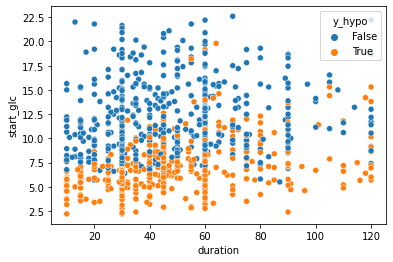

In [17]:
import seaborn as sns
sns.scatterplot(X.duration, X.start_glc, hue=y)

100%|███████| 60/60 [00:07<00:00,  7.58trial/s, best loss: -0.8850276709874233]
Accuracy of predicting training data = 0.7939972714870396
Accuracy of predicting test data = 0.7959183673469388


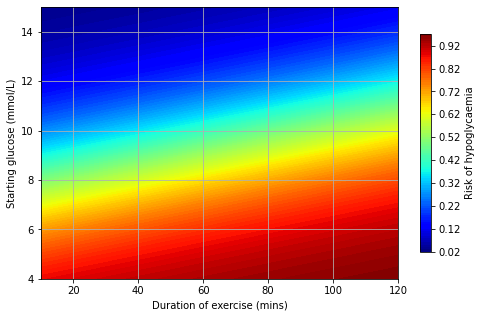

In [20]:
contour_plot = ml_help.create_contour_plot(X,y, params, 10, 120)
#3 dps

### 4.2.1. Logistic regression

In [8]:
y.value_counts()

False    513
True     465
Name: y_hypo, dtype: int64

In [22]:
contour_plot.add_subplots()

AttributeError: 'Figure' object has no attribute 'add_subplots'

100%|███████████████████████████████████████████████| 60/60 [00:08<00:00,  7.33trial/s, best loss: -0.8908519472530851]
Accuracy of predicting training data = 0.7962466487935657
Accuracy of predicting test data = 0.7510204081632653


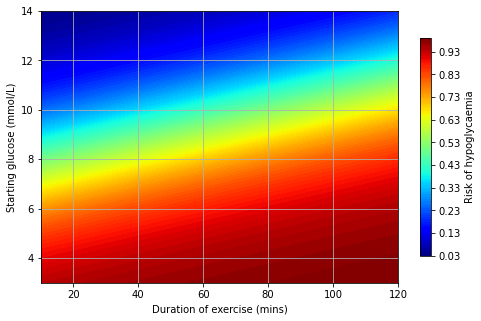

In [9]:
contour_plot = ml_help.create_contour_plot(X,y, params, 10, 120, True)

In [9]:
test_indices, observed, predicted, predicted_proba, coeffs, list_shap_values = model_helper.run_k_fold_model(X, y, LogisticRegression, params, strat, number_of_splits=10, smote=SMOTE)

 65%|██████████████████████████████▌                | 39/60 [00:02<00:01, 14.74trial/s, best loss: -0.8882169740157607]


KeyboardInterrupt: 

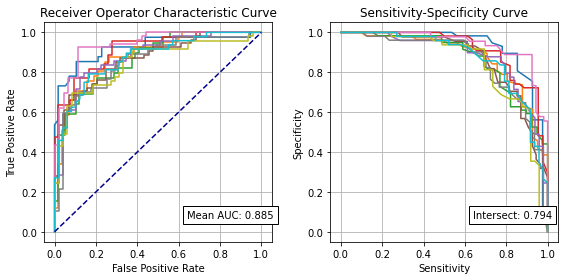

In [9]:
# 2 features
log_threshold_curves, k_fold_auc, k_fold_sens_spec = ml_help.k_fold_threshold_curves(observed, predicted_proba)
#log_threshold_curves.savefig(fig_directory+'roc_curve_during_lr_2_features.svg')

In [10]:
mean_accuracy, log_single_fit_results = model_helper.calculate_k_fold_results(observed, predicted)

In [11]:
k_fold_results = log_single_fit_results.T
k_fold_results['roc_auc'] = k_fold_auc
k_fold_results['sens_spec'] = k_fold_sens_spec

In [12]:
k_fold_results.to_csv(accuracy_directory+'k_fold_accuracies_'+period_str+'_lr_2_features.csv', index=False)

In [13]:
mean_ci = ml_help.calculate_ci_paper_format(k_fold_results)
mean_ci['model'] = 'lr'
mean_ci['features'] = 'start_glc+duration'
summary_results.append(mean_ci)

summary_results.append(['LR', 'start_glc+duration', mean_auc, sd_auc, sens_spec, mean_accuracy.loc['accuracy']['mean']])

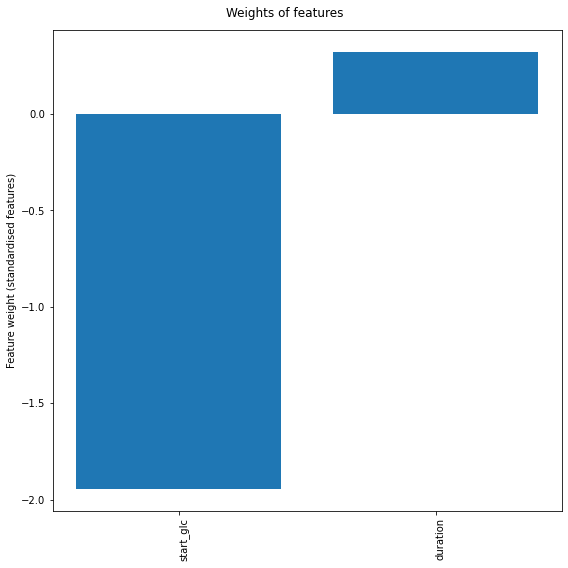

In [14]:
weights, weights_fig = model_helper.calculate_coefficient(coeffs, X.columns)
weights_fig.savefig(fig_directory+'weights_'+period_str+'_lr_2_features.svg')
weights.to_csv(weights_directory+'weights_'+period_str+'_lr_2_features.csv', index=False)

In [15]:
shap_values = model_helper.calculate_shap(list_shap_values)

In [16]:
%%capture
#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
fig, ax = plt.subplots()
ax = shap.summary_plot(shap_values, X)
#fig.suptitle('XGBoost - SHAP summary plot')
fig.savefig(fig_directory+'shap_summary_'+period_str+'_lr_2_features.svg')

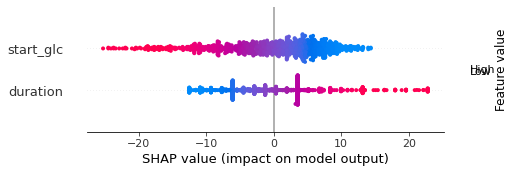

In [17]:
fig

In [18]:
%%capture
fig, ax = plt.subplots(1,2, figsize=(12, 5))
shap.plots.scatter(shap_values[:,'start_glc'], color=shap_values,
                          ax=ax[0])
shap.plots.scatter(shap_values[:,'duration'], color=shap_values,
                          ax=ax[1])
fig.tight_layout()

fig.savefig(fig_directory+'shap_dependence_'+period_str+'_lr_2_features.svg')

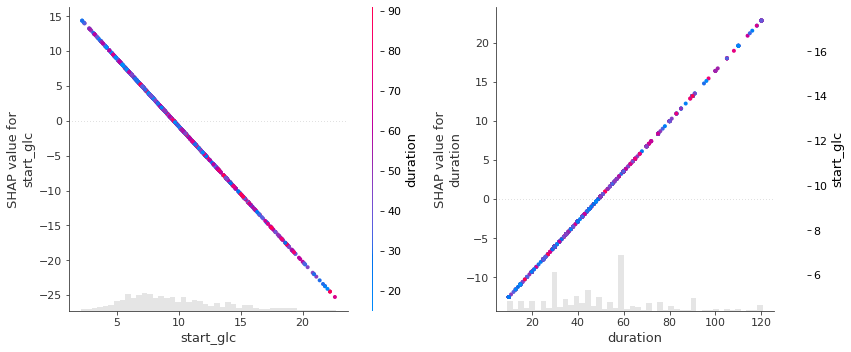

In [19]:
fig

### 4.2.2. XGBoost

In [20]:
X_test, observed, predicted, predicted_proba, list_shap_values = model_helper.run_k_fold_xgb(X, y, strat, number_of_splits= N_SPLITS, by_id=False, smote=SMOTE, tune_hp=TUNE)
#clear_output()#wait=True)

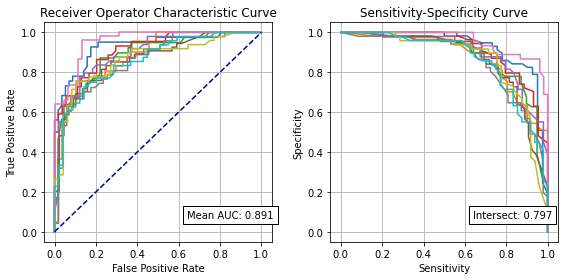

In [21]:
# 2 features
log_threshold_curves, k_fold_auc, k_fold_sens_spec = ml_help.k_fold_threshold_curves(observed, predicted_proba)
log_threshold_curves.savefig(fig_directory+'roc_curve_'+period_str+'_xgb_2_features.svg')

In [22]:
mean_accuracy, log_single_fit_results = model_helper.calculate_k_fold_results(observed, predicted)
#mean_accuracy.to_csv(accuracy_directory+'mean_accuracy_during_xgb_2_features_.csv', index=False)
#log_single_fit_results.to_csv(accuracy_directory+'k_fold_accuracies_during_xgb_2_features.csv', index=False)

In [23]:
k_fold_results = log_single_fit_results.T
k_fold_results['roc_auc'] = k_fold_auc
k_fold_results['sens_spec'] = k_fold_sens_spec

In [24]:
k_fold_results.to_csv(accuracy_directory+'k_fold_accuracies_'+period_str+'_xgb_2_features.csv', index=False)

In [25]:
mean_ci = ml_help.calculate_ci_paper_format(k_fold_results)
mean_ci['model'] = 'xgb'
mean_ci['features'] = 'start_glc+duration'
summary_results.append(mean_ci)

summary_results.append(['XGB', 'start_glc+duration', mean_auc, sd_auc, sens_spec, mean_accuracy.loc['accuracy']['mean']])

In [26]:
shap_values = model_helper.calculate_shap(list_shap_values)

In [27]:
%%capture
#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
fig, ax = plt.subplots()
ax = shap.summary_plot(shap_values, X)
#fig.suptitle('XGBoost - SHAP summary plot')
fig.savefig(fig_directory+'shap_summary_'+period_str+'_xgb_2_features.svg')

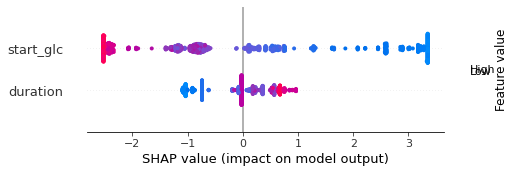

In [28]:
fig

In [29]:
%%capture
fig, ax = plt.subplots(1,2, figsize=(12, 5))
shap.plots.scatter(shap_values[:,'start_glc'], color=shap_values,
                          ax=ax[0])
shap.plots.scatter(shap_values[:,'duration'], color=shap_values,
                          ax=ax[1])
fig.tight_layout()

fig.savefig(fig_directory+'shap_dependence_'+period_str+'_xgb_2_features.svg')

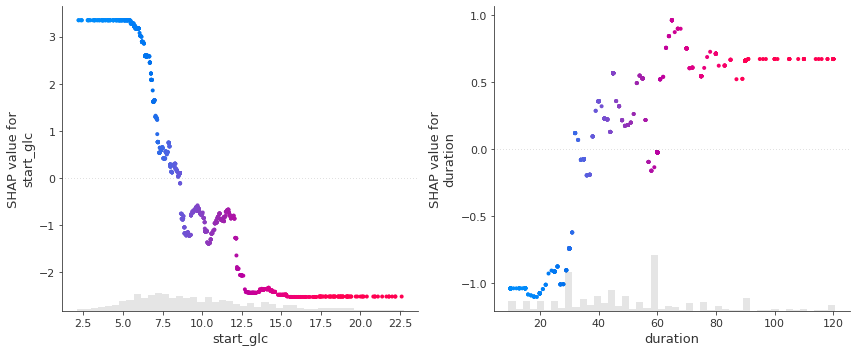

In [30]:
fig

## 4.2. Simple features only

In [31]:
simple_features = ['intensity', 'day_of_week', 'time_of_day', 'duration', 'form_of_exercise', 'start_glc', 'age', 'sex', 'years_since_diagnosis', 'bmi', 'hba1c', 'cpep']

In [32]:
#X = df.drop(columns=target_columns+['stratify'])
X = df[simple_features]
y = df[target_columns[0]]

In [33]:
X = pd.get_dummies(X)
imputer = KNNImputer(n_neighbors=K_NEIGHBOURS)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

### 4.2.1. Logistic regression

In [34]:
test_indices, observed, predicted, predicted_proba, coeffs, list_shap_values = model_helper.run_k_fold_model(X, y, LogisticRegression, params, strat, number_of_splits=10, smote=SMOTE)

100%|███████████████████████████████████████████████| 60/60 [00:03<00:00, 19.48trial/s, best loss: -0.8812956826872351]


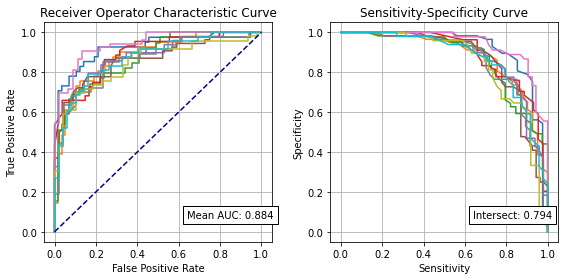

In [35]:
# 2 features
log_threshold_curves, k_fold_auc, k_fold_sens_spec = ml_help.k_fold_threshold_curves(observed, predicted_proba)
log_threshold_curves.savefig(fig_directory+'roc_curve_'+period_str+'_lr_simple_features.svg')

In [36]:
mean_accuracy, log_single_fit_results = model_helper.calculate_k_fold_results(observed, predicted)

In [37]:
k_fold_results = log_single_fit_results.T
k_fold_results['roc_auc'] = k_fold_auc
k_fold_results['sens_spec'] = k_fold_sens_spec

In [38]:
k_fold_results.to_csv(accuracy_directory+'k_fold_accuracies_'+period_str+'_lr_simple_features.csv', index=False)

In [39]:
mean_ci = ml_help.calculate_ci_paper_format(k_fold_results)
mean_ci['model'] = 'lr'
mean_ci['features'] = 'simple'
summary_results.append(mean_ci)

mean_accuracy.to_csv(accuracy_directory+'mean_accuracy_during_lr_simple_features.csv', index=False)
log_single_fit_results.to_csv(accuracy_directory+'k_fold_accuracies_during_lr_simple_features.csv', index=False)

summary_results.append(['LR', 'simple', mean_auc, sd_auc, sens_spec, mean_accuracy.loc['accuracy']['mean']])

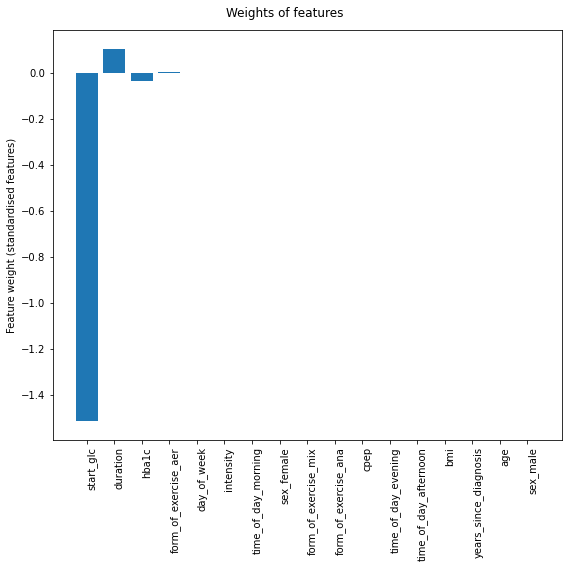

In [40]:
weights, weights_fig = model_helper.calculate_coefficient(coeffs, X.columns)
weights_fig.savefig(fig_directory+'weights_'+period_str+'_lr_simple_features.svg')
weights.to_csv(weights_directory+'weights_'+period_str+'_lr_simple_features.csv',
               index=False)

In [41]:
shap_values = model_helper.calculate_shap(list_shap_values)

In [42]:
%%capture
#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
fig, ax = plt.subplots()
ax = shap.summary_plot(shap_values, X)
#fig.suptitle('XGBoost - SHAP summary plot')
fig.savefig(fig_directory+'shap_summary_'+period_str+'_lr_simple_features.svg')

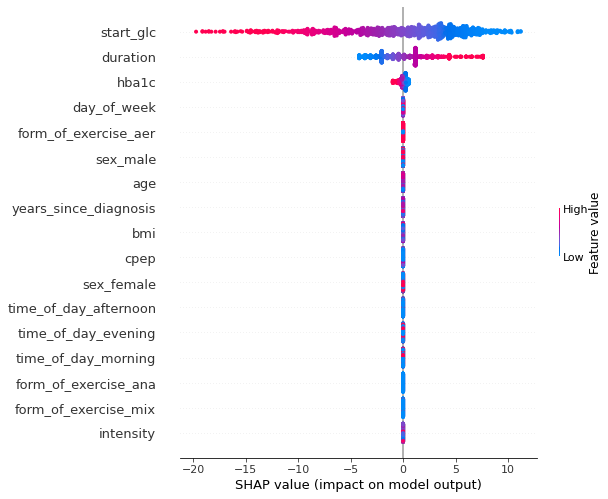

In [43]:
fig

In [44]:
%%capture
fig, ax = plt.subplots(1,2, figsize=(12, 5))
shap.plots.scatter(shap_values[:,'start_glc'], color=shap_values,
                          ax=ax[0])
shap.plots.scatter(shap_values[:,'duration'], color=shap_values,
                          ax=ax[1])
fig.tight_layout()

fig.savefig(fig_directory+'shap_dependence_'+period_str+'_lr_simple_features.svg')

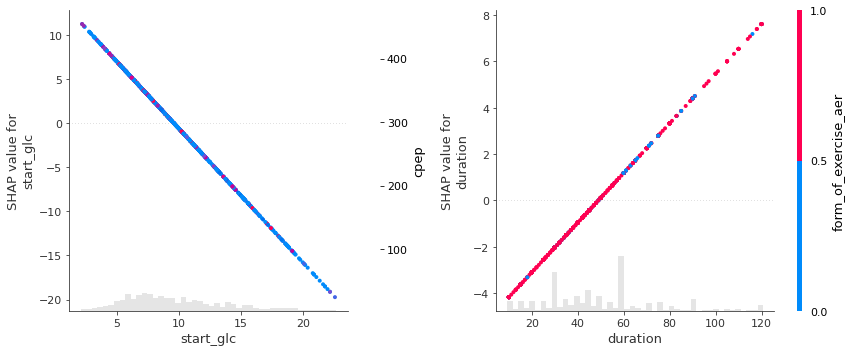

In [45]:
fig

### 4.2.2. XGBoost

In [46]:
X_test, observed, predicted, predicted_proba, list_shap_values = model_helper.run_k_fold_xgb(X, y, strat, number_of_splits= N_SPLITS, by_id=False, smote=SMOTE, tune_hp=TUNE)
#clear_output()#wait=True)

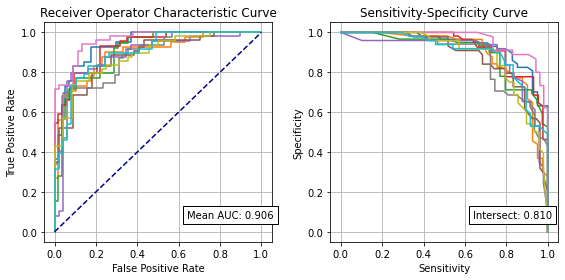

In [47]:
log_threshold_curves, k_fold_auc, k_fold_sens_spec = ml_help.k_fold_threshold_curves(observed, predicted_proba)
log_threshold_curves.savefig(fig_directory+'roc_curve_'+period_str+'_xgb_simple_features.svg')

In [48]:
mean_accuracy, log_single_fit_results = model_helper.calculate_k_fold_results(observed, predicted)
#mean_accuracy.to_csv(accuracy_directory+'mean_accuracy_during_xgb_simple_features.csv', index=False)
#log_single_fit_results.to_csv(accuracy_directory+'k_fold_accuracies_during_xgb_simple_features.csv', index=False)

In [49]:
k_fold_results = log_single_fit_results.T
k_fold_results['roc_auc'] = k_fold_auc
k_fold_results['sens_spec'] = k_fold_sens_spec

In [50]:
k_fold_results.to_csv(accuracy_directory+'k_fold_accuracies_'+period_str+'_xgb_simple_features.csv', index=False)

In [51]:
mean_ci = ml_help.calculate_ci_paper_format(k_fold_results)
mean_ci['model'] = 'xgb'
mean_ci['features'] = 'simple'
summary_results.append(mean_ci)

summary_results.append(['XGB', 'simple', mean_auc, sd_auc, sens_spec, mean_accuracy.loc['accuracy']['mean']])

In [52]:
shap_values = model_helper.calculate_shap(list_shap_values)

In [53]:
%%capture
#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
fig, ax = plt.subplots()
ax = shap.summary_plot(shap_values, X)
#fig.suptitle('XGBoost - SHAP summary plot')
fig.savefig(fig_directory+'shap_summary_'+period_str+'_xgb_simple_features.svg')

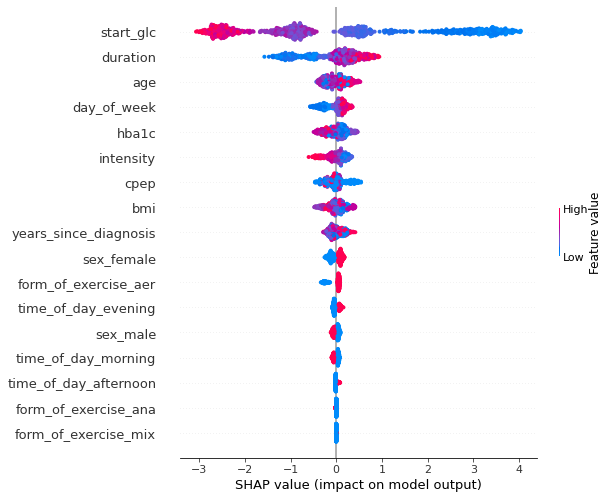

In [54]:
fig

In [55]:
%%capture
fig, ax = plt.subplots(1,2, figsize=(12, 5))
shap.plots.scatter(shap_values[:,'start_glc'], color=shap_values,
                          ax=ax[0])
shap.plots.scatter(shap_values[:,'duration'], color=shap_values,
                          ax=ax[1])
fig.tight_layout()

fig.savefig(fig_directory+'shap_dependence_'+period_str+'_xgb_simple_features.svg')

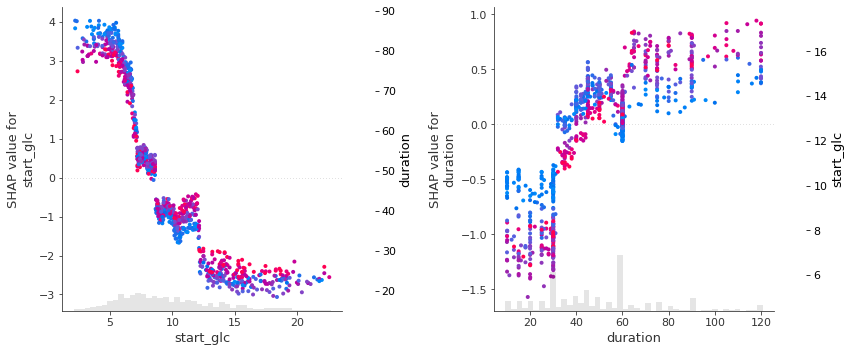

In [56]:
fig

## 4.1. Glycemic features

In [57]:
FILENAME = 'ml_during_glyc.csv'
df = pd.read_csv(directory + FILENAME)
df.day_of_week = df.day_of_week.astype(str)
df['season']=(df.month%12 // 3 + 1).astype(str)
#df.month = df.month.astype(str) # let's have a nosey
#df.ID = df.ID.astype(str)

df.drop(columns=['ID', 'month'], inplace=True)
target_columns = ['y_hypo']#, 'y_hyper']
strat = df['stratify']

In [58]:
X = df.drop(columns=target_columns+['stratify'])
y = df[target_columns[0]]

In [59]:
X = pd.get_dummies(X)
imputer = KNNImputer(n_neighbors=K_NEIGHBOURS)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

### 4.1.1. Logistic regression

In [60]:
test_indices, observed, predicted, predicted_proba, coeffs, list_shap_values = model_helper.run_k_fold_model(X, y, LogisticRegression, params, strat, number_of_splits=10, smote=SMOTE)

100%|███████████████████████████████████████████████| 60/60 [00:05<00:00, 11.99trial/s, best loss: -0.8838440554354003]


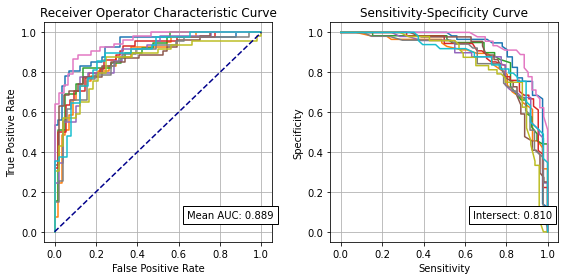

In [61]:
# glyc only
log_threshold_curves, k_fold_auc, k_fold_sens_spec = ml_help.k_fold_threshold_curves(observed, predicted_proba)
log_threshold_curves.savefig(fig_directory+'roc_curve_'+period_str+'_lr_glyc.svg')

In [62]:
mean_accuracy, log_single_fit_results = model_helper.calculate_k_fold_results(observed, predicted)

In [63]:
k_fold_results = log_single_fit_results.T
k_fold_results['roc_auc'] = k_fold_auc
k_fold_results['sens_spec'] = k_fold_sens_spec

In [64]:
k_fold_results.to_csv(accuracy_directory+'k_fold_accuracies_'+period_str+'_lr_glyc.csv', index=False)

In [65]:
mean_ci = ml_help.calculate_ci_paper_format(k_fold_results)
mean_ci['model'] = 'lr'
mean_ci['features'] = 'glyc'
summary_results.append(mean_ci)

mean_accuracy.to_csv(accuracy_directory+'mean_accuracy_during_lr_glyc_.csv', index=False)
log_single_fit_results.to_csv(accuracy_directory+'k_fold_accuracies_during_lr_glyc.csv', index=False)

summary_results.append(['LR', 'glyc', mean_auc, sd_auc, sens_spec, mean_accuracy.loc['accuracy']['mean']])

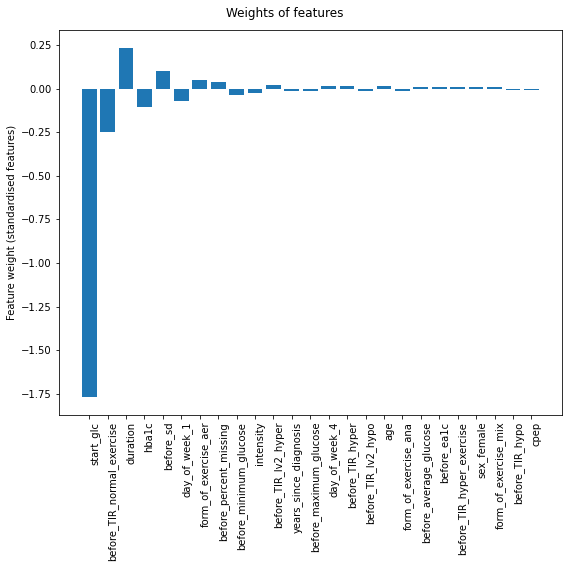

In [66]:
weights, weights_fig = model_helper.calculate_coefficient(coeffs, X.columns)
weights_fig.savefig(fig_directory+'weights_'+period_str+'_lr_glyc.svg')
weights.to_csv(weights_directory+'weights_'+period_str+'_lr_glyc.csv', index=False)

In [67]:
shap_values = model_helper.calculate_shap(list_shap_values)

In [68]:
%%capture
#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
fig, ax = plt.subplots()
ax = shap.summary_plot(shap_values, X)
#fig.suptitle('Logistic regression - SHAP summary plot')
fig.savefig(fig_directory+'shap_summary_'+period_str+'_lr_glyc.svg')

In [69]:
%%capture
log_dep_plt = ml_help.dependence_plots('', X, shap_values)
log_dep_plt.savefig(fig_directory+'shap_dependence_'+period_str+'_lr_glyc.svg')

### 4.1.2. XGBoost

In [70]:
X_test, observed, predicted, predicted_proba, list_shap_values = model_helper.run_k_fold_xgb(X, y, strat, number_of_splits= N_SPLITS, by_id=False, smote=SMOTE, tune_hp=TUNE)
#clear_output()#wait=True)

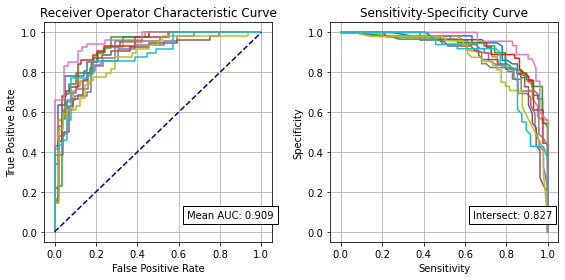

In [71]:
log_threshold_curves, k_fold_auc, k_fold_sens_spec = ml_help.k_fold_threshold_curves(observed, predicted_proba)
log_threshold_curves.savefig(fig_directory+'roc_curve_'+period_str+'_xgb_glyc.svg')

In [72]:
mean_accuracy, log_single_fit_results = model_helper.calculate_k_fold_results(observed, predicted)

In [73]:
k_fold_results = log_single_fit_results.T
k_fold_results['roc_auc'] = k_fold_auc
k_fold_results['sens_spec'] = k_fold_sens_spec

In [74]:
k_fold_results.to_csv(accuracy_directory+'k_fold_accuracies_'+period_str+'_xgb_glyc.csv', index=False)

In [75]:
mean_ci = ml_help.calculate_ci_paper_format(k_fold_results)
mean_ci['model'] = 'xgb'
mean_ci['features'] = 'glyc'
summary_results.append(mean_ci)

mean_accuracy.to_csv(accuracy_directory+'mean_accuracy_during_xgb_glyc_.csv', index=False)
log_single_fit_results.to_csv(accuracy_directory+'k_fold_accuracies_during_xgb_glyc.csv', index=False)

summary_results.append(['XGB', 'glyc', mean_auc, sd_auc, sens_spec, mean_accuracy.loc['accuracy']['mean']])

In [76]:
shap_values = model_helper.calculate_shap(list_shap_values)

In [77]:
%%capture
#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
fig, ax = plt.subplots()
ax = shap.summary_plot(shap_values, X)
#fig.suptitle('XGBoost - SHAP summary plot')
fig.savefig(fig_directory+'shap_summary_'+period_str+'_xgb_glyc.svg')

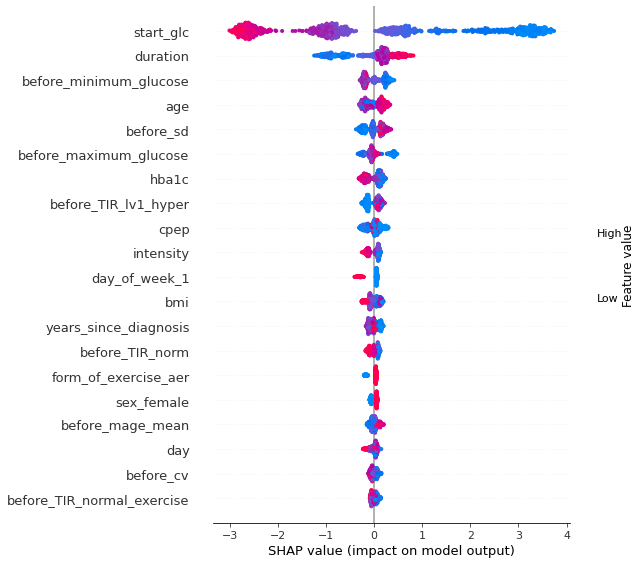

In [78]:
fig

In [79]:
%%capture
dep_plt = ml_help.dependence_plots('', X, shap_values)

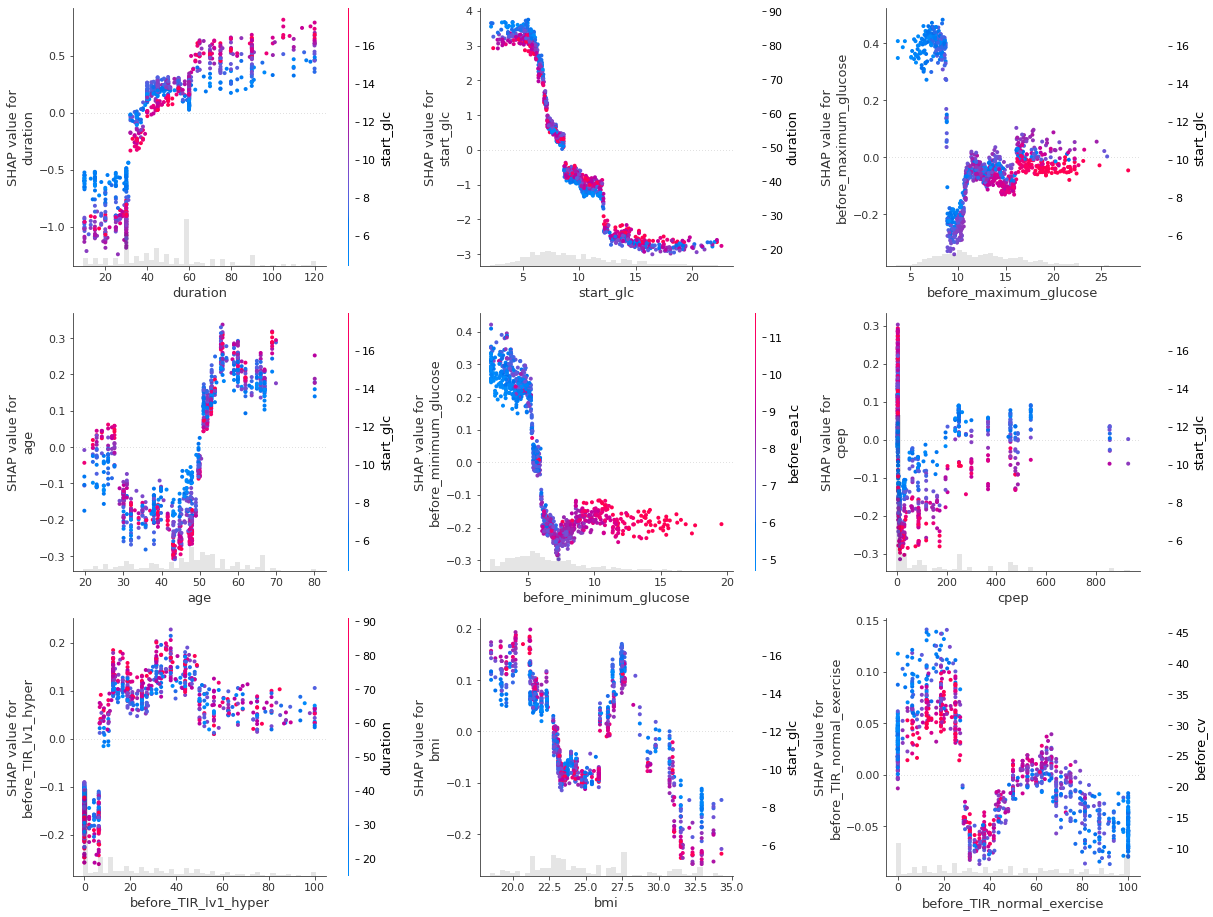

In [80]:
dep_plt

In [81]:
dep_plt.savefig(fig_directory+'shap_dependence_'+period_str+'_xgb_glyc.svg')

## 4.3. tsfresh

with open("features_xgb_during_ts", "rb") as fp:   #Unpickling 
    selected_cols = pickle.load(fp)

In [82]:
FILENAME = 'ml_during_glyc_ts.csv'
df = pd.read_csv(directory + FILENAME)
df.day_of_week = df.day_of_week.astype(str)
df['season']=df.month%12 // 3 + 1
#df.month = df.month.astype(str) # let's have a nosey
#df.ID = df.ID.astype(str)
df.drop(columns=['ID', 'month'], inplace=True)
target_columns = ['y_hypo']#, 'y_hyper']
strat = df['stratify']

In [83]:
X = df.drop(columns=target_columns+['stratify'])
y = df[target_columns[0]]

In [84]:
X = pd.get_dummies(X)
imputer = KNNImputer(n_neighbors=K_NEIGHBOURS)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X = X[selected_cols]

#### 4.3.1. Logistic regression

In [85]:
test_indices, observed, predicted, predicted_proba, coeffs, list_shap_values = model_helper.run_k_fold_model(X, y, LogisticRegression, params, strat, number_of_splits=10, smote=SMOTE)

100%|███████████████████████████████████████████████| 60/60 [02:21<00:00,  2.36s/trial, best loss: -0.8791306604092867]


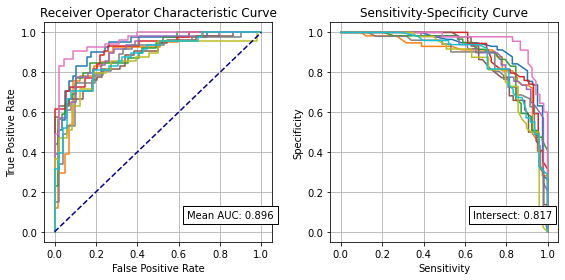

In [86]:
# w/ ts
log_threshold_curves, k_fold_auc, k_fold_sens_spec = ml_help.k_fold_threshold_curves(observed, predicted_proba)
log_threshold_curves.savefig(fig_directory+'roc_curve_'+period_str+'_lr_ts.svg')

In [87]:
mean_accuracy, log_single_fit_results = model_helper.calculate_k_fold_results(observed, predicted)
#mean_accuracy.to_csv(accuracy_directory+'mean_accuracy_during_lr_ts_.csv', index=False)
#log_single_fit_results.to_csv(accuracy_directory+'k_fold_accuracies_during_lr_ts.csv', index=False)

In [88]:
k_fold_results = log_single_fit_results.T
k_fold_results['roc_auc'] = k_fold_auc
k_fold_results['sens_spec'] = k_fold_sens_spec

In [89]:
k_fold_results.to_csv(accuracy_directory+'k_fold_accuracies_'+period_str+'_lr_ts.csv', index=False)

In [90]:
mean_ci = ml_help.calculate_ci_paper_format(k_fold_results)
mean_ci['model'] = 'lr'
mean_ci['features'] = 'ts'
summary_results.append(mean_ci)

summary_results.append(['LR', 'ts', mean_auc, sd_auc, sens_spec, mean_accuracy.loc['accuracy']['mean']])

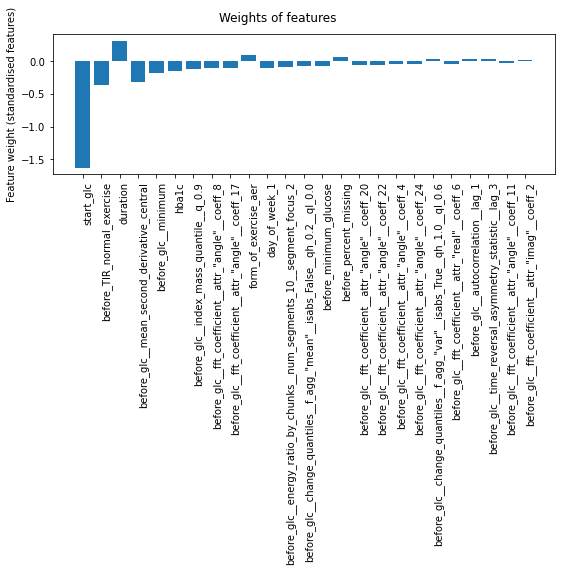

In [91]:
weights, weights_fig = model_helper.calculate_coefficient(coeffs, X.columns)
weights_fig.savefig(fig_directory+'weights_'+period_str+'_lr_ts.svg')
weights.to_csv(weights_directory+'weights_'+period_str+'_lr_ts.csv', index=False)

In [92]:
shap_values = model_helper.calculate_shap(list_shap_values)

In [93]:
%%capture
#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
fig, ax = plt.subplots()
ax = shap.summary_plot(shap_values, X)
#fig.suptitle('Logistic regression - SHAP summary plot')
fig.savefig(fig_directory+'shap_summary_'+period_str+'_lr_ts.svg')

In [94]:
%%capture
log_dep_plt = ml_help.dependence_plots('', X, shap_values)
log_dep_plt.savefig(fig_directory+'shap_dependence_'+period_str+'_lr_ts.svg')

#### 4.3.2. XGBoost

In [95]:
X_test, observed, predicted, predicted_proba, list_shap_values = model_helper.run_k_fold_xgb(X, y, strat, number_of_splits= N_SPLITS, by_id=False, smote=SMOTE, tune_hp=TUNE)

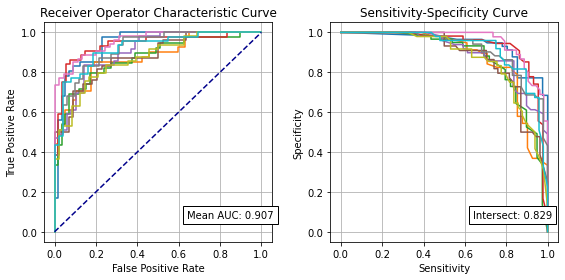

In [96]:
# all features
log_threshold_curves, k_fold_auc, k_fold_sens_spec = ml_help.k_fold_threshold_curves(observed, predicted_proba)
log_threshold_curves.savefig(fig_directory+'roc_curve_'+period_str+'_xgb_ts.svg')

In [97]:
mean_accuracy, log_single_fit_results = model_helper.calculate_k_fold_results(observed, predicted)
#mean_accuracy.to_csv(accuracy_directory+'mean_accuracy_during_xgb_ts_.csv', index=False)
#log_single_fit_results.to_csv(accuracy_directory+'k_fold_accuracies_during_xgb_ts.csv', index=False)

In [98]:
k_fold_results = log_single_fit_results.T
k_fold_results['roc_auc'] = k_fold_auc
k_fold_results['sens_spec'] = k_fold_sens_spec

In [99]:
k_fold_results.to_csv(accuracy_directory+'k_fold_accuracies_'+period_str+'_xgb_ts.csv', index=False)

In [100]:
mean_ci = ml_help.calculate_ci_paper_format(k_fold_results)
mean_ci['model'] = 'xgb'
mean_ci['features'] = 'ts'
summary_results.append(mean_ci)

summary_results.append(['XGB', 'ts', mean_auc, sd_auc, sens_spec, mean_accuracy.loc['accuracy']['mean']])

In [101]:
shap_values = model_helper.calculate_shap(list_shap_values)

In [102]:
%%capture
#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
fig, ax = plt.subplots()
ax = shap.summary_plot(shap_values, X)
#fig.suptitle('XGBoost - SHAP summary plot')
fig.savefig(fig_directory+'shap_summary_'+period_str+'_xgb_ts.svg')

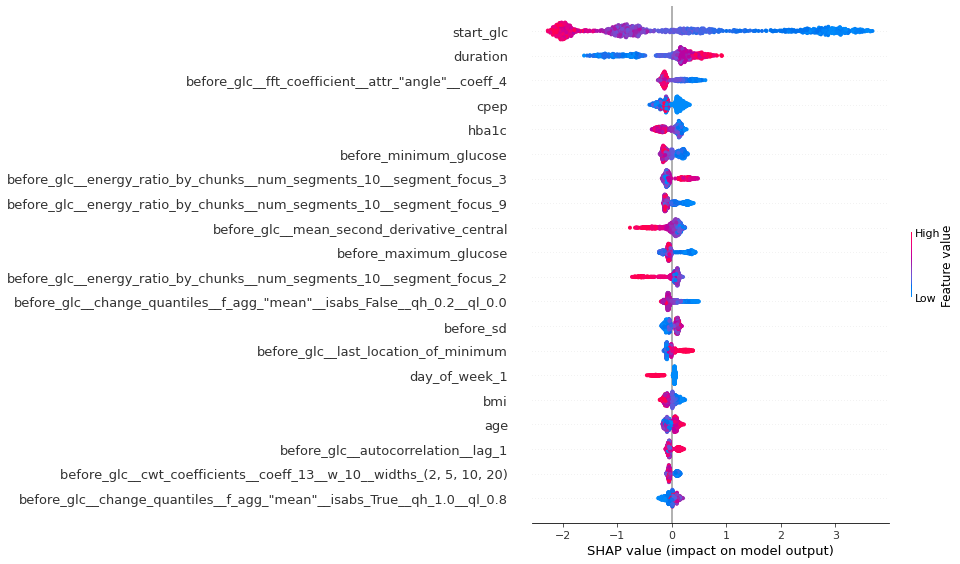

In [103]:
fig

In [104]:
%%capture
dep_plt = ml_help.dependence_plots('', X, shap_values)

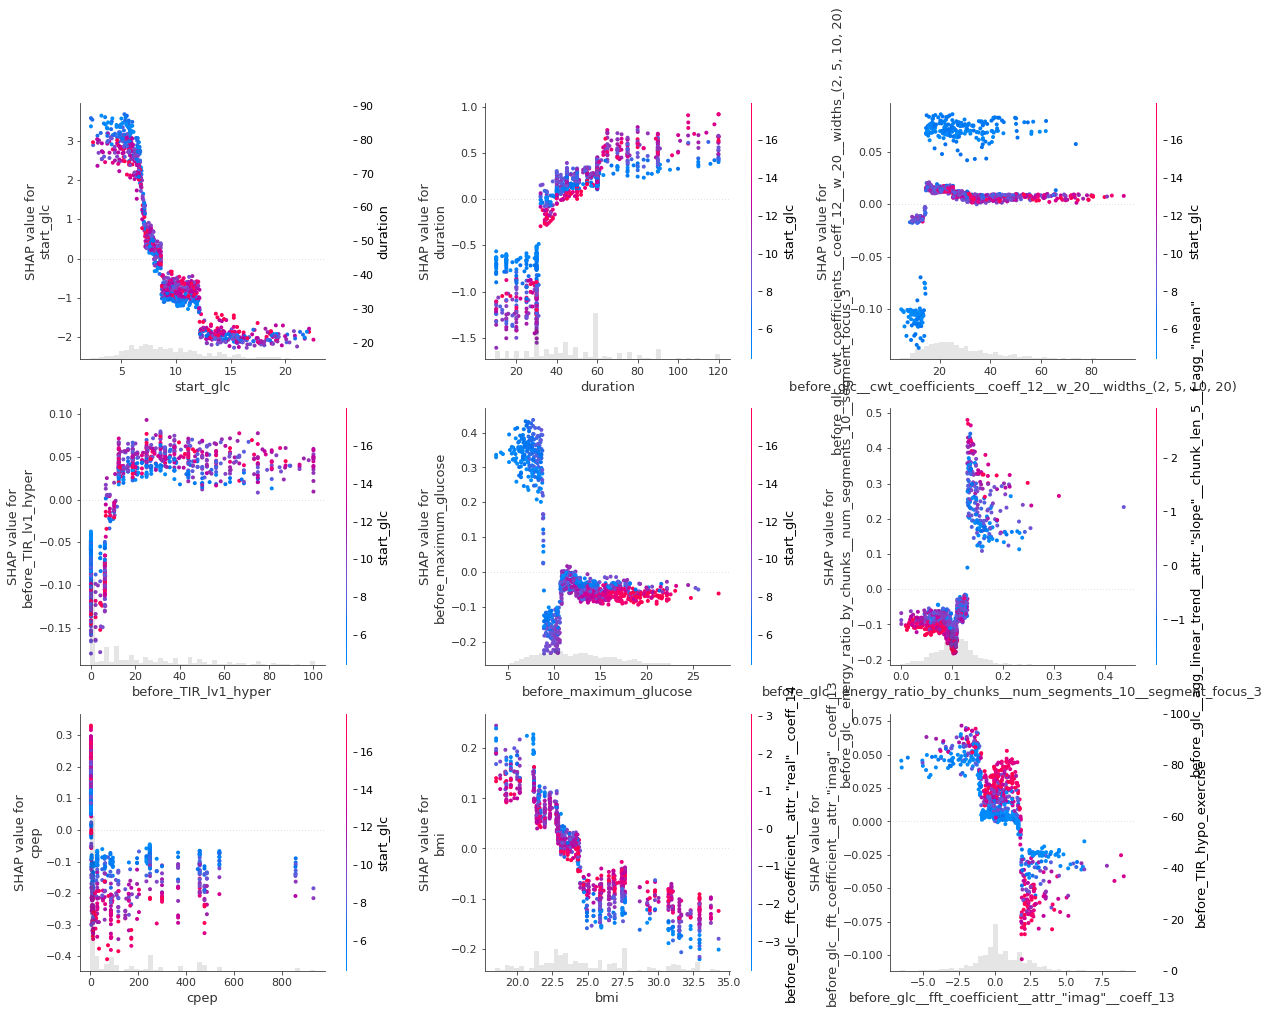

In [105]:
dep_plt

In [107]:
dep_plt.savefig(fig_directory+'shap_dependence_'+period_str+'_xgb_ts.svg')

## 4.4. Results

In [109]:
total_results = pd.DataFrame(summary_results)

In [110]:
total_results['period'] = period_str

In [111]:
total_results

,observed_positive_rate,observed_negative_rate,predicted_positive_rate,predicted_negative_rate,accuracy,precision,recall,f1,sensitivity,specificity,positive_likelihood,negative_likelihood,false_positive_rate,false_negative_rate,true_positive_rate,true_negative_rate,positive_predictive_value,negative_predictive_value,roc_auc,sens_spec,model,features,period
0,0.476 (0.443-0.508),0.524 (0.492-0.557),0.478 (0.444-0.511),0.522 (0.489-0.556),0.802 (0.767-0.836),0.788 (0.751-0.825),0.791 (0.752-0.831),0.789 (0.751-0.828),0.791 (0.752-0.831),0.807 (0.772-0.842),4.602 (3.352-5.851),0.263 (0.207-0.319),0.193 (0.158-0.228),0.209 (0.169-0.248),0.791 (0.752-0.831),0.807 (0.772-0.842),0.791 (0.752-0.831),0.807 (0.772-0.842),0.885 (0.865-0.904),0.794 (0.764-0.824),lr,start_glc+duration,during
1,0.476 (0.443-0.508),0.524 (0.492-0.557),0.45 (0.411-0.489),0.55 (0.511-0.589),0.805 (0.78-0.829),0.812 (0.775-0.849),0.767 (0.722-0.813),0.786 (0.757-0.815),0.767 (0.722-0.813),0.839 (0.804-0.873),5.193 (4.239-6.146),0.277 (0.227-0.327),0.161 (0.127-0.196),0.233 (0.187-0.278),0.767 (0.722-0.813),0.839 (0.804-0.873),0.767 (0.722-0.813),0.839 (0.804-0.873),0.891 (0.87-0.912),0.797 (0.776-0.819),XGB,start_glc+duration,during
2,0.476 (0.443-0.508),0.524 (0.492-0.557),0.478 (0.444-0.511),0.522 (0.489-0.556),0.795 (0.767-0.823),0.782 (0.752-0.811),0.785 (0.754-0.816),0.783 (0.753-0.814),0.785 (0.754-0.816),0.801 (0.771-0.831),4.243 (3.357-5.13),0.271 (0.227-0.315),0.199 (0.169-0.229),0.215 (0.184-0.246),0.785 (0.754-0.816),0.801 (0.771-0.831),0.785 (0.754-0.816),0.801 (0.771-0.831),0.884 (0.866-0.902),0.794 (0.769-0.819),lr,simple,during
3,0.476 (0.443-0.508),0.524 (0.492-0.557),0.404 (0.369-0.439),0.596 (0.561-0.631),0.826 (0.81-0.842),0.875 (0.857-0.894),0.742 (0.708-0.776),0.801 (0.784-0.818),0.742 (0.708-0.776),0.901 (0.88-0.922),8.317 (6.587-10.047),0.286 (0.252-0.319),0.099 (0.078-0.12),0.258 (0.224-0.292),0.742 (0.708-0.776),0.901 (0.88-0.922),0.742 (0.708-0.776),0.901 (0.88-0.922),0.905 (0.888-0.922),0.81 (0.786-0.835),xgb,simple,during
4,0.476 (0.443-0.508),0.524 (0.492-0.557),0.478 (0.444-0.511),0.522 (0.489-0.556),0.816 (0.799-0.833),0.803 (0.784-0.823),0.807 (0.786-0.828),0.805 (0.785-0.825),0.807 (0.786-0.828),0.821 (0.8-0.841),4.666 (4.011-5.322),0.236 (0.209-0.264),0.179 (0.159-0.2),0.193 (0.172-0.214),0.807 (0.786-0.828),0.821 (0.8-0.841),0.807 (0.786-0.828),0.821 (0.8-0.841),0.889 (0.87-0.907),0.81 (0.79-0.829),lr,glyc,during
5,0.476 (0.443-0.508),0.524 (0.492-0.557),0.427 (0.39-0.465),0.573 (0.535-0.61),0.819 (0.798-0.84),0.844 (0.817-0.871),0.759 (0.712-0.805),0.797 (0.769-0.824),0.759 (0.712-0.805),0.873 (0.851-0.896),6.42 (5.351-7.489),0.275 (0.227-0.323),0.127 (0.104-0.149),0.241 (0.195-0.288),0.759 (0.712-0.805),0.873 (0.851-0.896),0.759 (0.712-0.805),0.873 (0.851-0.896),0.908 (0.891-0.925),0.827 (0.808-0.847),xgb,glyc,during
6,0.476 (0.443-0.508),0.524 (0.492-0.557),0.478 (0.444-0.511),0.522 (0.489-0.556),0.82 (0.801-0.84),0.808 (0.787-0.828),0.811 (0.789-0.834),0.809 (0.788-0.831),0.811 (0.789-0.834),0.825 (0.802-0.847),4.839 (4.089-5.589),0.23 (0.201-0.259),0.175 (0.153-0.198),0.189 (0.166-0.211),0.811 (0.789-0.834),0.825 (0.802-0.847),0.811 (0.789-0.834),0.825 (0.802-0.847),0.896 (0.877-0.915),0.817 (0.793-0.84),lr,ts,during
7,0.476 (0.443-0.508),0.524 (0.492-0.557),0.425 (0.382-0.469),0.575 (0.531-0.618),0.821 (0.792-0.85),0.852 (0.814-0.89),0.763 (0.691-0.835),0.799 (0.762-0.835),0.763 (0.691-0.835),0.879 (0.845-0.913),7.427 (5.368-9.485),0.265 (0.186-0.343),0.121 (0.087-0.155),0.237 (0.165-0.309),0.763 (0.691-0.835),0.879 (0.845-0.913),0.763 (0.691-0.835),0.879 (0.845-0.913),0.907 (0.887-0.926),0.829 (0.811-0.846),xgb,ts,during


In [112]:
total_results.to_csv(total_accuracy_directory+'total_results_'+period_str+'.csv', index=False)

In [96]:
results = pd.DataFrame(summary_results, columns=['model','features','auc','sd_auc', 'sens-spec','accuracy']).round(4)
results.to_csv(total_accuracy_directory+'total_results_'+period_str+'.csv', index=False)

In [97]:
results

,model,features,auc,sd_auc,sens-spec,accuracy
0,LR,start_glc+duration,0.8852,0.0290,0.8017,0.8016
1,XGB,start_glc+duration,0.8919,0.0323,0.8033,0.8098
2,LR,simple,0.8840,0.0272,0.8027,0.7975
3,XGB,simple,0.9032,0.0231,0.8107,0.8169
4,LR,glyc,0.8894,0.0272,0.8012,0.8077
5,XGB,glyc,0.9063,0.0237,0.8147,0.8067
6,LR,ts,0.8963,0.0297,0.8123,0.8139
7,XGB,ts,0.9031,0.0333,0.8310,0.8282


#### Recreate test set

In [98]:
tested_frame = df.iloc[test_indices[0]]
tested_frame['predicted'] = predicted[0]
tested_frame['predicted_proba'] = predicted_proba[0]

for i in range(1, len(test_indices)):
    frame = df.iloc[test_indices[i]]
    frame['predicted'] = predicted[i]
    frame['predicted_proba'] = predicted_proba[i]
    tested_frame = tested_frame.append(frame)

In [99]:
tested_frame.drop(columns=['y_hyper'], inplace=True)

KeyError: "['y_hyper'] not found in axis"

In [ ]:
tested_frame.to_csv('results_frame_during_hypo_strat.csv', index=False)

# Other stuff

#### Other metrics

In [ ]:
shap_values = model_helper.calculate_shap(list_shap_values)

In [ ]:
%%capture
#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
fig, ax = plt.subplots()
ax = shap.summary_plot(shap_values, X)
fig.suptitle('Logistic regression - SHAP summary plot')

In [ ]:
fig

In [ ]:
%%capture
log_dep_plt = ml_help.dependence_plots('Logistic regression - SHAP dependence plots', X, shap_values)

In [ ]:
log_dep_plt

### 4.1.2. Stratify by ID, i.e. train and test set have different people

#### Set X and y

In [ ]:
id_col = df['ID']
X = df.drop(columns=target_columns+['stratify']+['ID'])

In [ ]:
X = pd.get_dummies(X)
imputer = KNNImputer(n_neighbors=K_NEIGHBOURS)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

#### Run model

In [ ]:
test_indices, observed, predicted, predicted_proba, coeffs, list_shap_values = model_helper.run_k_fold_model(X, y, LogisticRegression, params, id_col, number_of_splits=10, by_id=True, smote=SMOTE)

#### Recreate test set

In [ ]:
tested_frame = df.iloc[test_indices[0]]
tested_frame['predicted'] = predicted[0]
tested_frame['predicted_proba'] = predicted_proba[0]

for i in range(1, len(test_indices)):
    frame = df.iloc[test_indices[i]]
    frame['predicted'] = predicted[i]
    frame['predicted_proba'] = predicted_proba[i]
    tested_frame = tested_frame.append(frame)

In [ ]:
tested_frame.drop(columns=['y_hyper'], inplace=True)

In [ ]:
tested_frame.to_csv('results_frame_during_hypo_split.csv', index=False)

#### ROC AUC and sensitivity-specificity curves

In [ ]:
log_threshold_curves, mean_auc, sens_spec = ml_help.k_fold_threshold_curves(observed, predicted_proba)

#### Other metrics

In [ ]:
mean_accuracy, log_single_fit_results = model_helper.calculate_k_fold_results(observed, predicted)

In [ ]:
mean_accuracy

In [ ]:
summary_results.append(['LR', 'hypo', 'split', mean_auc, sens_spec, mean_accuracy.loc['accuracy']['mean']])

In [ ]:
weights, weights_fig = model_helper.calculate_coefficient(coeffs, X.columns)

In [ ]:
weights

In [ ]:
weights_fig.savefig('hypo_during_weights.png')

In [ ]:
shap_values = model_helper.calculate_shap(list_shap_values)

In [ ]:
%%capture
#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
fig, ax = plt.subplots()
ax = shap.summary_plot(shap_values, X)
fig.suptitle('Logistic regression - SHAP summary plot')

In [ ]:
fig

In [ ]:
shap.plots.scatter(shap_values[:,'start_glc'], color=shap_values,
                          ax=ax)

In [ ]:
shap.plots.scatter(shap_values[:,'duration'], color=shap_values,
                          ax=ax)

In [ ]:
%%capture
log_dep_plt = ml_help.dependence_plots('Logistic regression - SHAP dependence plots', X, shap_values)

In [ ]:
log_dep_plt

## 4.2. Predicting hyperglycemia (>12)

#### Set X and y

In [ ]:
X = df.drop(columns=target_columns+['stratify'])
y = df[target_columns[1]]

In [ ]:
X = pd.get_dummies(X)
imputer = KNNImputer(n_neighbors=K_NEIGHBOURS)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

### 4.2.1. Stratify by ID and target

#### Run model

In [ ]:
test_indices, observed, predicted, predicted_proba, coeffs, list_shap_values = model_helper.run_k_fold_model(X, y, LogisticRegression, params, strat, number_of_splits=10, smote=SMOTE)

#### Recreate test set

In [ ]:
tested_frame = df.iloc[test_indices[0]]
tested_frame['predicted'] = predicted[0]
tested_frame['predicted_proba'] = predicted_proba[0]

for i in range(1, len(test_indices)):
    frame = df.iloc[test_indices[i]]
    frame['predicted'] = predicted[i]
    frame['predicted_proba'] = predicted_proba[i]
    tested_frame = tested_frame.append(frame)

In [ ]:
tested_frame.drop(columns=['y_hypo'], inplace=True)

In [ ]:
tested_frame.to_csv('results_frame_during_hyper_strat.csv', index=False)

#### ROC AUC and sensitivity-specificity curves

In [ ]:
log_threshold_curves, mean_auc, sens_spec = ml_help.k_fold_threshold_curves(observed, predicted_proba)

#### Other metrics

In [ ]:
mean_accuracy, log_single_fit_results = model_helper.calculate_k_fold_results(observed, predicted)

In [ ]:
mean_accuracy

In [ ]:
summary_results.append(['LR', 'hyper', 'strat', mean_auc, sens_spec, mean_accuracy.loc['accuracy']['mean']])

In [ ]:
weights, weights_fig = model_helper.calculate_coefficient(coeffs, X.columns)

In [ ]:
shap_values = model_helper.calculate_shap(list_shap_values)  

In [ ]:
%%capture
#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
fig, ax = plt.subplots()
ax = shap.summary_plot(shap_values, X)
fig.suptitle('Logistic regression - SHAP summary plot')

In [ ]:
fig

In [ ]:
%%capture
log_dep_plt = ml_help.dependence_plots('Logistic regression - SHAP dependence plots', X, shap_values)

In [ ]:
log_dep_plt

### 4.2.2. Stratify by ID, i.e. train and test set have different people

#### Set X and y

In [ ]:
X = df.drop(columns=target_columns+['stratify']+['ID'])
id_col = df['ID']

In [ ]:
X = pd.get_dummies(X)
imputer = KNNImputer(n_neighbors=K_NEIGHBOURS)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

#### Run model

In [ ]:
test_indices, observed, predicted, predicted_proba, coeffs, list_shap_values = model_helper.run_k_fold_model(X, y, LogisticRegression, params, id_col, number_of_splits=10, by_id=True, smote=SMOTE)

#### Recreate test set

In [ ]:
tested_frame = df.iloc[test_indices[0]]
tested_frame['predicted'] = predicted[0]
tested_frame['predicted_proba'] = predicted_proba[0]

for i in range(1, len(test_indices)):
    frame = df.iloc[test_indices[i]]
    frame['predicted'] = predicted[i]
    frame['predicted_proba'] = predicted_proba[i]
    tested_frame = tested_frame.append(frame)

In [ ]:
test_indices

In [ ]:
tested_frame.drop(columns=['y_hypo'], inplace=True)

In [ ]:
tested_frame.to_csv('results_frame_during_hyper_split.csv', index=False)

#### ROC AUC and sensitivity-specificity curves

In [ ]:
log_threshold_curves, mean_auc, sens_spec = ml_help.k_fold_threshold_curves(observed, predicted_proba)

#### Other metrics

In [ ]:
mean_accuracy, log_single_fit_results = model_helper.calculate_k_fold_results(observed, predicted)

In [ ]:
mean_accuracy

In [ ]:
summary_results.append(['LR', 'hyper', 'split', mean_auc, sens_spec, mean_accuracy.loc['accuracy']['mean']])

In [ ]:
weights, weights_fig = model_helper.calculate_coefficient(coeffs, X.columns)

In [ ]:
weights_fig.savefig('hyper_during_weights.png')

In [ ]:
shap_values = model_helper.calculate_shap(list_shap_values)

In [ ]:
%%capture
#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
fig, ax = plt.subplots()
ax = shap.summary_plot(shap_values, X)
fig.suptitle('Logistic regression - SHAP summary plot')

In [ ]:
fig

In [ ]:
%%capture
log_dep_plt = ml_help.dependence_plots('Logistic regression - SHAP dependence plots', X, shap_values)

In [ ]:
log_dep_plt

## 4.3. Summary ROC AUC and sensitivity-specificity intersect

In [ ]:
results = pd.DataFrame(summary_results, columns=['model', 'glycemia', 'strat_split', 'mean_auc', 'sens_spec', 'accuracy']).round(3)
results['smote'] = SMOTE
results['k_neighbours'] = K_NEIGHBOURS
results